
Celem ćwiczenia była implementacja metody realizującej algorytm genetyczny w wersji Holanda, a następnie przebadanie wpływu zmiany parametru mutacji na zachowanie algorytmu.

W celu implementacji metody stworzono klasę *individual* zawierającą parametry pojedynczego osobnika (*genes*, *fitness*, *rpr_prob*), a więc jego genotyp, wynik funkcji celu, oraz prawdopodobieństwo znalezienia się w populacji rodziców.

Następnie opracowano funkcje:
*   *fitness* - oblicza funkcję celu, została okrojona do części znajdującej się w szeregu zadanej funkcji celu, ponieważ minimalizacja:

f1.png

jest maksymalizacją ogólnej funkcji celu:

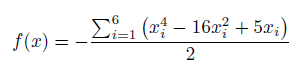

*   *fit_sort* - funkcja przypisująca każdemu osobnikowi wynik fitness, oraz sortująca osobniki względem tego parametru

*   *roulette* - funkcja symulująca wybór ruletkowy osobników do reprodukcji. Jako że funkcja celu przyjmuje wartości zarówno dodatnie jak i ujemne, nie było możliwości wyliczenia prawdopodobieństwa ze stosunku wyniku funkcji celu dla jednego osobnika do sumy wyników funkcji celu wszystkich osobników. Dlatego zdecydowano się na faworyzowanie osobników w kolejności posortowania i tak dla osobnika 1 prawdopodobieństwo wyboru na rodzica wynosi 0.5, osobnika 2 0.25, osobnika 3 0.125 itd. Ostatnie dwa osobniki posiadają takie samo proawdopodobieństwo wyboru. Następnym etapem było losowanie rodziców z uwględnieniem prawdopodobieństw i tak losowano liczbę random z zakresu 0-1 gdy

 random <= 0.5 wybierano pierwszego osobnika, gdy 
 
 0.5 < random <= 0.75 wybierano drugiego osobnika itd. 



*   *cross_mut* - funkcja realizująca reprodukcję i mutację. Z populacji wytypowanych rodziców losowo znajduje 2, potem kopiuje ich genotypy do dzieci, a następni z prawdopodobieństwem krzyżowania dokonuje krzyżowania względem losowego punktu w wektorze genotypu każdego z osobników. Natępnie z prawdopodobieństwem mutacji dokonuje zmiany jednego bitu na przeciwny.

Wprowadzenie możliwych rozwiązań zrealizowano za pomocą wektorów binarnych 3 elementowych, ponieważ w przedziale \[-3,4] jest 8 liczb, więc zdecydowano się na zamianę wektora binarnego na wartość dziesiętną, po czym w funkcji fitness odjęcie 4, tak aby odwzorować wymagane wartości.







Best number: -3


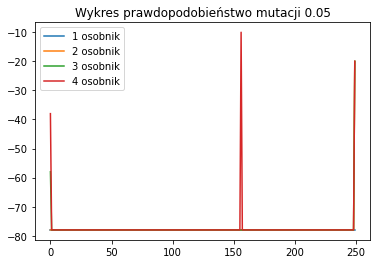

Best number: -3


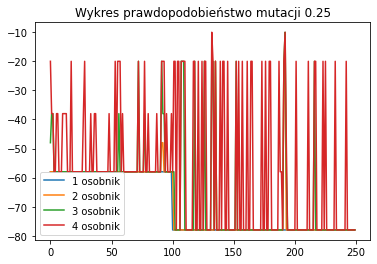

Best number: -3


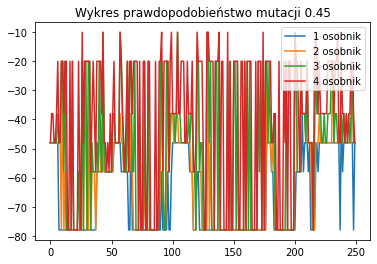

Best number: -3


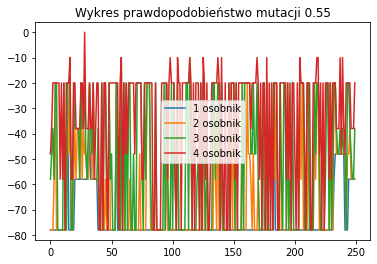

In [ ]:
#author = Michał Iskra

import numpy as np
!pip install bitstring
from bitstring import BitArray
import random
import math
import copy
import matplotlib.pyplot as plt



class individual:  
    def __init__(self, genes, fitness, rpr_prob = 0):  
        self.genes = genes
        self.fitness = fitness 
        self.rpr_prob = rpr_prob

def fitness(bitlist): ##Aby zmaksymalizować funkcję f z zadania, możemy rozpatrywać tak naprawdę minimalizację funkcji która jest wewnątrz szeregu
    b = BitArray(bitlist)
    x = b.uint - 4
    return x**4 - 16*x**2 + 5*x

def fit_sort(population, fitness_func):
    for individual in population:
        individual.fitness = fitness_func(individual.genes)
    population = sorted(population, key= lambda obj: obj.fitness)
    return population
  

def roulette(sorted_population, size):

    counter = 0
    for individual in sorted_population:           ## Nadanie odpowiednich prawdopodobieństw na reprodukcje w zależności od miejsca w liście osobników -  sam wymyśliłem pierwszy osobnik prawdopodobieństwo 0.5, następny połowę mniej 0,25 itd.
        individual.rpr_prob = 0.5/2**counter         ## Normalne użycie prawdopodbieńśtwa nie sprawdzałoby się ponieważ funkcja celu przyjmuje zarówno dodatnie jak i ujemne wartości
        counter += 1       
    sorted_population[-1].rpr_prob = sorted_population[-1].rpr_prob*2           ##ostatnie dwa osobniki mają takie samo prawdopodobieństwo, aby suma dla prawdopodobieństw wszystkich osobników była równa 1
  
    Candidates = []
    for i in range(size):
        random = np.random.random() #wygenerowanie liczby z zakresu [0,1)
        sum = 0
        i = 0
        while(sum <= random):
            sum += sorted_population[i].rpr_prob
            i += 1
        Candidates.append(sorted_population[i-1]) #dodanie do kandydatów na rodziców wylosowane osobniki

    return Candidates



def cross_mut(parents_population, size, mut_prob, cross_prob):
    children_population = []
    for i in range(int(math.floor(size/2))):
        p1, p2 = random.choice(parents_population),random.choice(parents_population)
        c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)
        if np.random.random() < cross_prob:
		        point = random.randint(1, len(p1.genes)-1)            
		        c1.genes = np.concatenate((p1.genes[:point],p2.genes[point:]))
		        c2.genes = np.concatenate((p2.genes[:point],p1.genes[point:]))
        children_population.append(c1)
        children_population.append(c2)

    for child in children_population:
        if np.random.random() < mut_prob:
            point = random.randint(0, len(child.genes)-1)
            child.genes[point] = not child.genes[point]

    return children_population



def gen_algorithm(fitness_func, start_popul, popul_size, mut_prob=0.15, cross_prob=0.7, t_max=250):

    P = []
    for item in start_popul: #stworzenie listy osobników
        P.append(individual(item,fitness_func(item)))
    
    P = fit_sort(P,fitness_func) #posortowanie populacji według funkcji celu
    best = individual(P[0].genes,P[0].fitness) # wytypowanie najlepszego rozwiązania póki co

    experiment = []
    t = 0
    while(t<t_max):
        R = roulette(P, popul_size)
        M = cross_mut(R, popul_size, mut_prob, cross_prob)
        P = fit_sort(M, fitness_func)
        if P[0].fitness <= best.fitness:               #nadpisanie najlepszego osobnika w populacji
            best = individual(P[0].genes ,P[0].fitness)
        t += 1
        experiment.append(P)

    return best, experiment






popul = np.random.randint(2, size=(6,3))

#EKSPERYMENTY
result, experiment1 = gen_algorithm(fitness,popul,6,mut_prob = 0.05)
print("Best number: {}".format(BitArray(result.genes).uint - 4))

v1 = [[],[],[],[]]
for item in experiment1:
  v1[0].append(item[0].fitness)
  v1[1].append(item[1].fitness)
  v1[2].append(item[2].fitness)
  v1[3].append(item[3].fitness)

plt.plot(v1[0], label = "1 osobnik")
plt.plot(v1[1], label = "2 osobnik")
plt.plot(v1[2], label = "3 osobnik")
plt.plot(v1[3], label = "4 osobnik")
plt.title("Wykres prawdopodobieństwo mutacji 0.05")
plt.legend()
plt.show()

result, experiment2 = gen_algorithm(fitness,popul,6,mut_prob = 0.25)
print("Best number: {}".format(BitArray(result.genes).uint - 4))
v1 = [[],[],[],[]]
for item in experiment2:
  v1[0].append(item[0].fitness)
  v1[1].append(item[1].fitness)
  v1[2].append(item[2].fitness)
  v1[3].append(item[3].fitness)

plt.plot(v1[0], label = "1 osobnik")
plt.plot(v1[1], label = "2 osobnik")
plt.plot(v1[2], label = "3 osobnik")
plt.plot(v1[3], label = "4 osobnik")
plt.title("Wykres prawdopodobieństwo mutacji 0.25")
plt.legend()
plt.show()


result, experiment3 = gen_algorithm(fitness,popul,6,mut_prob = 0.45)
print("Best number: {}".format(BitArray(result.genes).uint - 4))
v1 = [[],[],[],[]]
for item in experiment3:
  v1[0].append(item[0].fitness)
  v1[1].append(item[1].fitness)
  v1[2].append(item[2].fitness)
  v1[3].append(item[3].fitness)

plt.plot(v1[0], label = "1 osobnik")
plt.plot(v1[1], label = "2 osobnik")
plt.plot(v1[2], label = "3 osobnik")
plt.plot(v1[3], label = "4 osobnik")
plt.title("Wykres prawdopodobieństwo mutacji 0.45")
plt.legend()
plt.show()

result, experiment4 = gen_algorithm(fitness,popul,6,mut_prob = 0.55)
print("Best number: {}".format(BitArray(result.genes).uint - 4))
v1 = [[],[],[],[]]
for item in experiment4:
  v1[0].append(item[0].fitness)
  v1[1].append(item[1].fitness)
  v1[2].append(item[2].fitness)
  v1[3].append(item[3].fitness)

plt.plot(v1[0], label = "1 osobnik")
plt.plot(v1[1], label = "2 osobnik")
plt.plot(v1[2], label = "3 osobnik")
plt.plot(v1[3], label = "4 osobnik")
plt.title("Wykres prawdopodobieństwo mutacji 0.55")
plt.legend()
plt.show()

Jak widać na wykresach wraz ze zwiększaniem prawdopodobieństwa mutacji algorytm częściej wyskakuje z minimum globalnego i tyczy się to nie tylko osobników słabszych, ale również tych które pojawiają się na początku populacji po sortowaniu.

Dzięki tej właściwości przy odpowiednim prawdopodobieństwie mutacji algorytm jest w stanie wyjść z minimum lokalnego dla bardziej złożonego problemu.

Małe prawdopodobieństo mutacji powoduje bardziej ustabilizowane wskazanie algorytmu, co w przypadku większej złożoności problemu może powodować potrzebę większej ilości iteracji aby dojść do minimum globalnego.

Za każdym razem algorytm zwrócił że liczba -3 daje maksimum funkcji zadanej.
